# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files
from tensorflow.keras import utils as np_utils
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from tensorflow.keras.regularizers import l1

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

idx = pd.IndexSlice

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


# Data Exploration

In [2]:
test_accuracy_by_model = {} # I will populate this throughout the notebook and display/discuss it at the bottom

In [3]:
print(f'There are {len(dog_names)} categories (dog breeds) in the dataset.')
if len(dog_names) != len(set(dog_names)):
    print('Duplicated labels were detected!')
else:
    print('No duplicate class labels were detected.')

There are 133 categories (dog breeds) in the dataset.
No duplicate class labels were detected.


In [4]:
breed_observations = pd.DataFrame(train_targets, columns=dog_names)
breed_observations_pct = breed_observations.sum().div(breed_observations.sum().sum())

Among the 133 breeds, the distribution is not very even. This following table and plot shows the percentage of all observations for each breed, in decsending order.

In [5]:
breed_observations_pct.sort_values(ascending=False).head(20)

Alaskan_malamute                  0.011527
Border_collie                     0.011078
Basset_hound                      0.010928
Dalmatian                         0.010629
Basenji                           0.010329
Bullmastiff                       0.010329
Bull_terrier                      0.010329
Cavalier_king_charles_spaniel     0.010030
Australian_cattle_dog             0.009880
Irish_terrier                     0.009880
American_staffordshire_terrier    0.009880
Australian_shepherd               0.009880
Boston_terrier                    0.009731
Dachshund                         0.009731
Briard                            0.009731
Bernese_mountain_dog              0.009731
Boxer                             0.009581
Belgian_sheepdog                  0.009581
Golden_retriever                  0.009581
Cane_corso                        0.009581
dtype: float32

<Axes: title={'center': 'Percent of Observations by Breed, Descending Order'}>

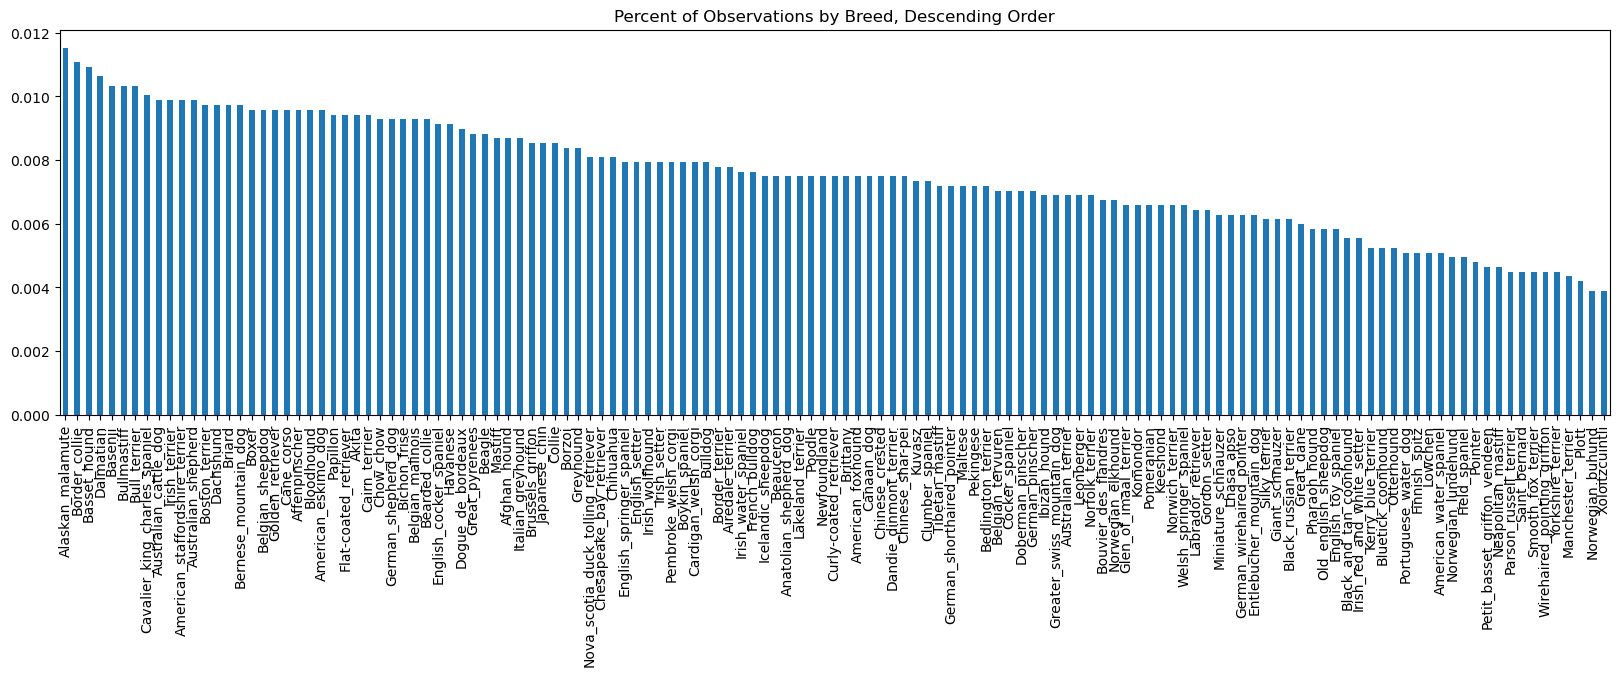

In [6]:
breed_observations_pct.sort_values(ascending=False).plot.bar(
    title='Percent of Observations by Breed, Descending Order',
    figsize=(20, 5)
)

Measuring the percentage of observations of each breed in training and testing datasets shows that the proportion of each is roughly similar (e.g. the slope of a scatterplot of each is close to a 45 degree angle).

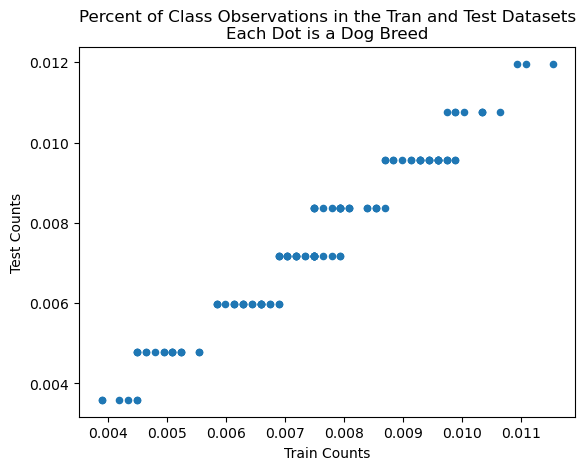

In [7]:
train_test_pct = pd.concat({
    'Train Counts': pd.DataFrame(train_targets, columns=dog_names).sum(),
    'Test Counts': pd.DataFrame(test_targets, columns=dog_names).sum(),
}, axis=1)
train_test_pct = train_test_pct.div(train_test_pct.sum())
train_test_pct.plot.scatter(
    x='Train Counts', y='Test Counts', 
    title='Percent of Class Observations in the Tran and Test Datasets\nEach Dot is a Dog Breed');

### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [8]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


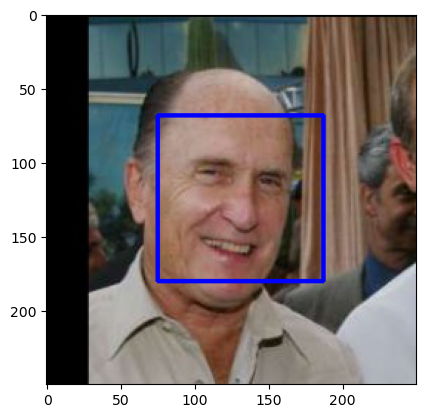

In [9]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [10]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

The face detector identified 100% of 100 humans as humans but it also identfiied 12% of 100 dogs as human too.

In [11]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

for label, files in {
    'humans as humans': human_files_short,
    'dogs as humans': dog_files_short,
    }.items():
    detected_count = np.array([face_detector(i) for i in files]).sum()
    detected_pct = detected_count/len(files)
    print(f'Deteced {detected_pct:.1%} of {len(files)} {label}')

Deteced 100.0% of 100 humans as humans
Deteced 12.0% of 100 dogs as humans


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [12]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [13]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

2024-12-14 10:59:34.542987: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-12-14 10:59:34.543005: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2024-12-14 10:59:34.543008: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
2024-12-14 10:59:34.543036: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-14 10:59:34.543049: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\tt{nb\_samples}, \tt{rows}, \tt{columns}, \tt{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $ \times $ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\tt{nb\_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [14]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [15]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img, verbose=False))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [16]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

The dog detector identified 0% of 100 humans as humans but identfiied 100% of 100 dogs as dogs. So, it appears that dog_detector is less prone to mis-detect a human as a dog than the face_detector was to detect a dog as a human.

In [17]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

for label, files in {
    'humans as dogs': human_files_short,
    'dogs as dogs': dog_files_short,
    }.items():
    detected_count = np.array([dog_detector(i) for i in files]).sum()
    detected_pct = detected_count/len(files)
    print(f'Deteced {detected_pct:.1%} of {len(files)} {label}')

2024-12-14 10:59:35.804494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Deteced 0.0% of 100 humans as dogs
Deteced 100.0% of 100 dogs as dogs


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [18]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:02<00:00, 380.53it/s]


In [19]:
# Set the seed for Python's random module
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

def build_model(
    input_shape,
    n_target_classes,
    loss_function='categorical_crossentropy', # for mutually exclusive class labels (like we have)
    optimizer='adam',
    eval_metrics=['accuracy'],
    filters_layer1=32, # typically powers of 2, starting smaller and getting larger in later layers - this is for layer 1
    filters_other_layers=64, # ... and this is for any other layers added in
    conv_strides=(1, 1), # (1, 1) prob preferable, (2, 2) will reduce dimensions a bit more
    pool_size=(2, 2), # stick with (2, 2)
    kernel_size_layer1=(3, 3), # larger for larger details, smaller for finer details - this is for layer 1
    kernel_size_other_layers=(3, 3), # .... and this is for any other layers added in
):
        """ Function to assemle a Sequential model, layer by layeer.

        Args:
            input_shape (tuple): The shape to pass to the first layer.
            n_target_classes (int): The number of classification targets.
            loss_function (str, optional): The loss function to use in the model. Defaults to 'categorical_crossentropy'.
            optimizer (str, optional): Optimizer to use. Defaults to 'adam'.
            eval_metrics (list, optional): Metric to use for scoring. Defaults to ['accuracy'].
            filters_layer1 (int, optional): Number of filters to create in the first layer. Defaults to 32.
            filters_other_layers (int, optional): Number of filters to create in the other layers. Defaults to 64.
            conv_strides (tuple, optional): Stride size. Defaults to (1, 1).
            pool_size (tuple, optional): Pooling size. Defaults to (2, 2).
            kernel_size_layer1 (tuple, optional): Kernel size for first layer. Defaults to (3, 3).
            kernel_size_other_layers (tuple, optional): Kernel size for other layers. Defaults to (3, 3).

        Returns:
            object: Compiled model object.
        """
        model = models.Sequential([
            # 1
            layers.Conv2D(
                filters=filters_layer1,
                kernel_size=kernel_size_layer1,
                strides=conv_strides,
                activation='relu', 
                padding='valid',
                input_shape=input_shape,
                ),
            layers.MaxPooling2D(pool_size=pool_size),
            
            # 2
            layers.Conv2D(
                filters=filters_other_layers,
                kernel_size=kernel_size_other_layers,
                strides=conv_strides,
                activation='relu',
                padding='valid',
                kernel_regularizer=l1(0.0002),
                # kernel_regularizer=l2(0.0002),
                ),
            layers.MaxPooling2D(pool_size=pool_size),

            layers.Flatten(),
            
            layers.Dense(n_target_classes, activation='relu'),
            layers.Dense(n_target_classes, activation='softmax')
        ])

        model.compile(
                optimizer=optimizer,
                loss=loss_function,
                metrics=eval_metrics,
                )
        
        return model

        
scratch_model = build_model(
        input_shape=train_tensors.shape[1:],
        n_target_classes=train_targets.shape[-1],
        optimizer='rmsprop', # or 'adam'
)

### (IMPLEMENTATION) Model Architecture

<!-- Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
            -->
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

I don't have extensive experience working with convolutional neural networks, so I started with some research on how to get started structuring a model for image classification. I acknowledge the following sources for their assistance:
- [DataCamp](https://www.datacamp.com/tutorial/introduction-to-convolutional-neural-networks-cnns)
- [AnalyticsVidhya](https://www.analyticsvidhya.com/blog/2019/01/build-image-classification-model-10-minutes/?utm_source=blog&utm_source=learn-image-classification-cnn-convolutional-neural-networks-5-datasets)
- [TensorFlow Documentation](https://www.tensorflow.org/tutorials/images/classification)
- [GeeksForGeeks](https://www.geeksforgeeks.org/python-image-classification-using-keras/)
- [TowardsDataScience](https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939)

Note: I also consulted [Microsoft's Copilot AI](https://copilot.microsoft.com/) to assist in putting together code from various libraries. In particlar, this was helpful in getting a Scitkit-Learn pipeline assembled with a wrapper around Keras, that I intended to use with GridSearchCV to fine tune my model. However, I found this approach burdensome (and also heavy on compute resources, and time). I did not further develop the pipeline, as I did not want to overfit this mode, and the code I built with AI assitance was disregarded. Further, Copilot was helpful in providing a useful boilerplate for the web app, where Python was used with Flask/Plotly/Bootstrap libararies.

The basic structure I found was:
- An initial convolutional layer, followed by a pooling layer.
- 2-3 additional convolutional layers, followed by pooling layers (except for the last)
- A flattening layer.
- Two dense layers (one using relu activation, the last using softmax activation).

I initially built a custom class to implement this structure, defininig various class attributes (hyperparameters) to pass into the various stages that I could fine tune (e.g. with GridSearchCV as mentioned in above). Additionally, I defined a simple Scitkit-Learn pipine hiolding the class. Howver, since data preprocessing is handled by the Udacity-provided code here, and the GridSearchCV method was cumbersome to implement as a wrapper - I decided not to continue with the pipeline, as the only element in the pipeline would be the estimator itself (the model class). Instead, I converted that clas into the **build_model()** function above. 

That said. I folowed some basic heuristics when specicying this model:
- The first convolution layer should have fewer filters than the following layers.
    - All those filters should be powers of 2.
- I experimented with kernel sizes (1x1, 2x2, 3x3).
- Strides were kept at (1x1) as I did not want too much dimensionality reduction, especially since I know this dataset will have classes that are difficult to distinguish.
- I experimented with L1 and L2 normalization through the various layers (but again, remaining wary of too much dimension reduction).
    - Applying L1 regularization - penalizing based on the absolute value of weights, which can push some weights to zero - in the second layer with a lambda of 0.0001 improved training accuracy slightly.
    - I experimented with various lambda values to determine an effecive scale for the parameter (starting with 0.01 and shrinking down to 0.00005).

Ultimately, by trial and error, the parameters defined as default function arguments in build_model() are those that I found to give a reasonably high level of accuracy on the training data.

Throughout this notebook, I am focusing on **accuracy** as the key model metric. Accuracy measures how well the model is predicting category across the training and testing images. While other metrics exist, accuracy is intuitive and makes sense for a classification algorithm where the prediction is binary (correct or not).


Worth noting:
- Earlier versions of the model had 3 Conv2D layers, but I found that dropping the last tended to roughly maintain the level of training accuracy.
- I also tested using the 'adam' optimizer, amd found 'rmsprop' a bit better in training accuracy.


### Compile the Model
- This step is contained within *build_model()*.

In [20]:
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [21]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 5

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

scratch_model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/5


2024-12-14 11:00:07.957695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


334/334 [==============================] - ETA: 0s - loss: 5.0519 - accuracy: 0.0189

2024-12-14 11:00:16.579256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 4.63375, saving model to saved_models/weights.best.from_scratch.hdf5
334/334 [==============================] - 9s 26ms/step - loss: 5.0519 - accuracy: 0.0189 - val_loss: 4.6337 - val_accuracy: 0.0491
Epoch 2/5
  3/334 [..............................] - ETA: 8s - loss: 4.4762 - accuracy: 0.1000 

/Users/justinclark/miniforge3/envs/udacity4/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


333/334 [============================>.] - ETA: 0s - loss: 4.2950 - accuracy: 0.0871
Epoch 2: val_loss improved from 4.63375 to 4.53508, saving model to saved_models/weights.best.from_scratch.hdf5
334/334 [==============================] - 9s 26ms/step - loss: 4.2954 - accuracy: 0.0870 - val_loss: 4.5351 - val_accuracy: 0.0647
Epoch 3/5
332/334 [============================>.] - ETA: 0s - loss: 2.4630 - accuracy: 0.4340
Epoch 3: val_loss did not improve from 4.53508
334/334 [==============================] - 8s 25ms/step - loss: 2.4601 - accuracy: 0.4346 - val_loss: 6.6647 - val_accuracy: 0.0419
Epoch 4/5
333/334 [============================>.] - ETA: 0s - loss: 0.8993 - accuracy: 0.8048
Epoch 4: val_loss did not improve from 4.53508
334/334 [==============================] - 8s 25ms/step - loss: 0.9006 - accuracy: 0.8046 - val_loss: 12.2069 - val_accuracy: 0.0491
Epoch 5/5
332/334 [============================>.] - ETA: 0s - loss: 0.4677 - accuracy: 0.9160
Epoch 5: val_loss did not i

Here, we pull out some evaluation metrics per training epoch. Note how accuracy starts low and increases rapidly, but then increases less rapidly (the accuracy_delta values gets smaller) into the last epoch. For this reason, I chose not to apply additional epochs (as doing so would likely be overfitting the model).

In [22]:
scratch_model_metrics = pd.DataFrame(scratch_model.history.history).rename_axis('Epoch', axis=0)
scratch_model_metrics = scratch_model_metrics.assign(accuracy_delta=lambda x: x['accuracy'].diff())
scratch_model_metrics.style.format('{:.2f}').set_caption('Evaluation Metrics Per Epoch')

,loss,accuracy,val_loss,val_accuracy,accuracy_delta
Epoch,,,,,
0,5.05,0.02,4.63,0.05,nan
1,4.30,0.09,4.54,0.06,0.07
2,2.46,0.43,6.66,0.04,0.35
3,0.90,0.80,12.21,0.05,0.37
4,0.47,0.92,21.73,0.04,0.11


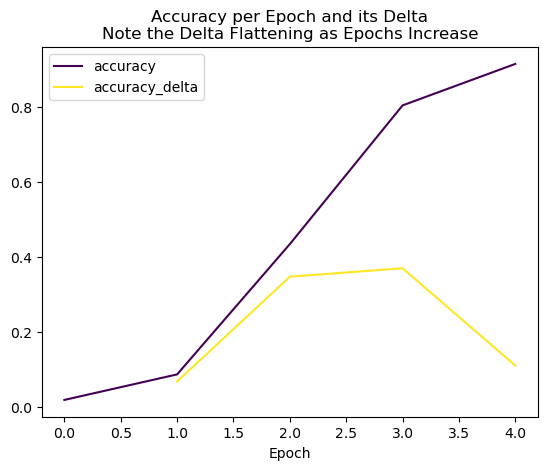

In [23]:
scratch_model_metrics[['accuracy', 'accuracy_delta']].plot(
    cmap='viridis',
    title='Accuracy per Epoch and its Delta\nNote the Delta Flattening as Epochs Increase'
    );

### Load the Model with the Best Validation Loss

In [24]:
scratch_model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [25]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(scratch_model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
test_accuracy_by_model['Scratch'] = test_accuracy
print('Test accuracy: %.4f%%' % test_accuracy)

1/1 [==============================] - 0s 8ms/step


2024-12-14 11:00:51.218634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 8ms/step
Test accuracy: 6.1005%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [26]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [27]:
VGG16_model = models.Sequential()
VGG16_model.add(layers.GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(layers.Dense(133, activation='softmax'))

VGG16_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 133)               68229     
                                                                 
Total params: 68229 (266.52 KB)
Trainable params: 68229 (266.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Compile the Model

In [28]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [29]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/20
 18/334 [>.............................] - ETA: 1s - loss: 21.4739 - accuracy: 0.0111    

2024-12-14 11:01:12.688597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


329/334 [============================>.] - ETA: 0s - loss: 8.1930 - accuracy: 0.2214

2024-12-14 11:01:14.777230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 3.47629, saving model to saved_models/weights.best.VGG16.hdf5
334/334 [==============================] - 2s 7ms/step - loss: 8.1296 - accuracy: 0.2243 - val_loss: 3.4763 - val_accuracy: 0.4491
Epoch 2/20
 28/334 [=>............................] - ETA: 1s - loss: 2.6006 - accuracy: 0.5054

/Users/justinclark/miniforge3/envs/udacity4/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


327/334 [============================>.] - ETA: 0s - loss: 2.2074 - accuracy: 0.5925
Epoch 2: val_loss improved from 3.47629 to 2.27568, saving model to saved_models/weights.best.VGG16.hdf5
334/334 [==============================] - 2s 6ms/step - loss: 2.2004 - accuracy: 0.5942 - val_loss: 2.2757 - val_accuracy: 0.6204
Epoch 3/20
329/334 [============================>.] - ETA: 0s - loss: 1.2567 - accuracy: 0.7309
Epoch 3: val_loss improved from 2.27568 to 2.16831, saving model to saved_models/weights.best.VGG16.hdf5
334/334 [==============================] - 2s 6ms/step - loss: 1.2618 - accuracy: 0.7307 - val_loss: 2.1683 - val_accuracy: 0.6491
Epoch 4/20
331/334 [============================>.] - ETA: 0s - loss: 0.8024 - accuracy: 0.8147
Epoch 4: val_loss improved from 2.16831 to 2.00935, saving model to saved_models/weights.best.VGG16.hdf5
334/334 [==============================] - 2s 6ms/step - loss: 0.8032 - accuracy: 0.8148 - val_loss: 2.0094 - val_accuracy: 0.6659
Epoch 5/20
333/

In [30]:
vgg16_model_metrics = pd.DataFrame(VGG16_model.history.history).rename_axis('Epoch', axis=0)
vgg16_model_metrics = vgg16_model_metrics.assign(accuracy_delta=lambda x: x['accuracy'].diff())
vgg16_model_metrics.style.format('{:.2f}').set_caption('Evaluation Metrics Per Epoch')

,loss,accuracy,val_loss,val_accuracy,accuracy_delta
Epoch,,,,,
0,8.13,0.22,3.48,0.45,nan
1,2.20,0.59,2.28,0.62,0.37
2,1.26,0.73,2.17,0.65,0.14
3,0.80,0.81,2.01,0.67,0.08
4,0.58,0.86,1.78,0.71,0.04
5,0.43,0.89,1.95,0.70,0.03
6,0.31,0.91,1.88,0.71,0.03
7,0.22,0.94,1.91,0.71,0.02
8,0.18,0.95,1.93,0.72,0.01


### Load the Model with the Best Validation Loss

In [31]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [32]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
test_accuracy_by_model['VGG16'] = test_accuracy
print('Test accuracy: %.4f%%' % test_accuracy)

1/1 [==============================] - 0s 8ms/step


2024-12-14 11:01:55.928983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 8ms/step
Test accuracy: 69.7368%


### Predict Dog Breed with the Model

In [33]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [34]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResNet50Data.npz')
train_justinBottle = bottleneck_features['train']
valid_justinBottle = bottleneck_features['valid']
test_justinBottle = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



In [35]:
### TODO: Define your architecture.
# model architecture
justinBottle_model = models.Sequential()
justinBottle_model.add(layers.GlobalAveragePooling2D(input_shape=train_justinBottle.shape[1:]))
justinBottle_model.add(layers.Dense(133, activation='softmax'))

# get summary
justinBottle_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 133)               272517    
                                                                 
Total params: 272517 (1.04 MB)
Trainable params: 272517 (1.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [36]:
### TODO: Compile the model.
# compile
justinBottle_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [37]:
### TODO: Train the model.
# train
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.justinBottle.hdf5', 
                               verbose=1, save_best_only=True)

justinBottle_model.fit(train_justinBottle, train_targets, 
          validation_data=(valid_justinBottle, valid_targets),
          epochs=5, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/5
 19/334 [>.............................] - ETA: 1s - loss: 5.3769 - accuracy: 0.0711

2024-12-14 11:02:14.209848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


326/334 [============================>.] - ETA: 0s - loss: 1.6531 - accuracy: 0.5900

2024-12-14 11:02:16.228507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.83552, saving model to saved_models/weights.best.justinBottle.hdf5
334/334 [==============================] - 2s 7ms/step - loss: 1.6338 - accuracy: 0.5945 - val_loss: 0.8355 - val_accuracy: 0.7269
Epoch 2/5
 28/334 [=>............................] - ETA: 1s - loss: 0.4529 - accuracy: 0.8696

/Users/justinclark/miniforge3/envs/udacity4/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


327/334 [============================>.] - ETA: 0s - loss: 0.4392 - accuracy: 0.8631
Epoch 2: val_loss improved from 0.83552 to 0.67190, saving model to saved_models/weights.best.justinBottle.hdf5
334/334 [==============================] - 2s 6ms/step - loss: 0.4384 - accuracy: 0.8638 - val_loss: 0.6719 - val_accuracy: 0.7988
Epoch 3/5
333/334 [============================>.] - ETA: 0s - loss: 0.2623 - accuracy: 0.9167
Epoch 3: val_loss did not improve from 0.67190
334/334 [==============================] - 2s 6ms/step - loss: 0.2622 - accuracy: 0.9165 - val_loss: 0.6948 - val_accuracy: 0.7868
Epoch 4/5
331/334 [============================>.] - ETA: 0s - loss: 0.1762 - accuracy: 0.9437
Epoch 4: val_loss improved from 0.67190 to 0.63881, saving model to saved_models/weights.best.justinBottle.hdf5
334/334 [==============================] - 2s 6ms/step - loss: 0.1766 - accuracy: 0.9434 - val_loss: 0.6388 - val_accuracy: 0.8120
Epoch 5/5
334/334 [==============================] - ETA: 0s 

In [38]:
bottleneck_model_metrics = pd.DataFrame(justinBottle_model.history.history).rename_axis('Epoch', axis=0)
bottleneck_model_metrics = bottleneck_model_metrics.assign(accuracy_delta=lambda x: x['accuracy'].diff())
bottleneck_model_metrics.style.format('{:.2f}').set_caption('Evaluation Metrics Per Epoch')

,loss,accuracy,val_loss,val_accuracy,accuracy_delta
Epoch,,,,,
0,1.63,0.59,0.84,0.73,nan
1,0.44,0.86,0.67,0.80,0.27
2,0.26,0.92,0.69,0.79,0.05
3,0.18,0.94,0.64,0.81,0.03
4,0.13,0.96,0.66,0.81,0.02


### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [39]:
### TODO: Load the model weights with the best validation loss.
# load model with best validation losss
justinBottle_model.load_weights('saved_models/weights.best.justinBottle.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [40]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
justinBottle_predictions = [np.argmax(justinBottle_model.predict(np.expand_dims(feature, axis=0))) for feature in test_justinBottle]

# report test accuracy
test_accuracy = 100*np.sum(np.array(justinBottle_predictions)==np.argmax(test_targets, axis=1))/len(justinBottle_predictions)
test_accuracy_by_model['Bottleneck'] = test_accuracy
print('Test accuracy: %.4f%%' % test_accuracy)

1/1 [==============================] - 0s 8ms/step


2024-12-14 11:02:25.063223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 9ms/step
Test accuracy: 81.6986%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [41]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

def predict_breed_from_image(img_path, model):
    """ Predict dog breed from image,

    Args:
        img_path (_type_): Path to image file.

    Returns:
        str: Predicted breed from image.
    """
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]    

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [42]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def classify_image(img_path, model):
    """ Function to predict a dog breed from an image, using provided mnodel.

    Args:
        img_path (str): Path to image file.
        model (object): Model to use for prediction.

    Returns:
        str: The predicted dog breed class.
    """
    # dog detected...
    is_dog = dog_detector(img_path)

    # person detected...
    is_human = face_detector(img_path)

    if is_dog or is_human:
        breed = predict_breed_from_image(img_path, model)
        if is_dog:
            answer = f'{img_path} contains a dog that looks like a: {breed}'
        else:
            answer = f'{img_path} contains a person who looks like a: {breed}'
    else:
        print(f'No dog or human was detected in this image: {img_path}')
        answer = -1
    return answer

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

The output of this model is better than I exepcted it to be (and funnier too). It seems to do a reasonable job of classifying the dog pictures, and in the images of people (especially Clint Eastwood) I can see a resemblence in the predicted breed.

I can think of a few ways to potentially improve the model:
- Introduce another "breed" category that is "human" and add images that include people to train the model on, to allow it to disambiguate dogs and humans more clearly.
- Add more layers to the training to attempt to key in on finer details from pictures.
- Experiment with hyperparameters (such as the optimizer, the number of epochs).
- Experiment with the layers themselves, such as by adding regularization (to potentially reduce overfit risks).

In [43]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
import os

test_image_dir = './downloaded_test_images'
for img_path in [os.path.join(test_image_dir, i) for i in os.listdir(test_image_dir)]:
    print(classify_image(img_path, justinBottle_model))

2024-12-14 11:02:43.223108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-14 11:02:44.732447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 23ms/step
./downloaded_test_images/image1.jpeg contains a dog that looks like a: Golden_retriever


2024-12-14 11:02:45.104811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-14 11:02:46.301949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 10ms/step
./downloaded_test_images/image6.jpeg contains a dog that looks like a: Bulldog


2024-12-14 11:02:47.761697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 11ms/step
./downloaded_test_images/image4.jpeg contains a dog that looks like a: Alaskan_malamute


2024-12-14 11:02:49.169086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 12ms/step
./downloaded_test_images/image5.jpeg contains a dog that looks like a: American_staffordshire_terrier
No dog or human was detected in this image: ./downloaded_test_images/not_dog_not_human.jpeg
-1


2024-12-14 11:02:50.602719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 10ms/step
./downloaded_test_images/image2.jpeg contains a person who looks like a: English_springer_spaniel


2024-12-14 11:02:52.166215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 11ms/step
./downloaded_test_images/image3.jpeg contains a person who looks like a: English_toy_spaniel


# This saves the model in TensorFlow format, so it can be loaded by the webapp.

In [44]:
model_save_file='./saved_models/justin_model'

justinBottle_model.save(model_save_file)

INFO:tensorflow:Assets written to: ./saved_models/justin_model/assets


INFO:tensorflow:Assets written to: ./saved_models/justin_model/assets


Below I compare the **training** accuracy (and accuracy delta) of 3 model variations: the VGG16 model, the "from scratch" model, and the bottleck model. Note that the later 2 only used 5 epochs (index labels 0 through 4) while the VGG16 model used 20 (0-19). While the VGG16 model eventually reached accuracy of 0.99 around epoch 15 (index 14), it was lower than the other 2 variants in epoch 5 (index 4).

Also, the Scratch model's accuracy delta was not decelerating as quickly as VGG16 or Bottleneck at the end of epoch 5 (index 4). At that stage, the VGG16 and especially the Bottleneck model wwere already showing small changes in accuracy.

In [45]:
pd.concat({
    'VGG16': vgg16_model_metrics,
    'Scratch': scratch_model_metrics,
    'Bottlneck': bottleneck_model_metrics,
}, axis=1).loc[:, idx[:, ['accuracy', 'accuracy_delta']]].style.format('{:.2f}', na_rep='-').set_caption(
    'Training Accurancy and Accuracy Delta Comparison by Model Variant'
)

Finally, we compare the **testing** accuracy of the 3 model variants. Here, we see the Scratch model accuracy far lower than the other 2 variants, indicating considerable overfit during training. However, the other 2 variants show solid accuracy (close to 70% for VGG16 and just under 82% for the Bottlenck model).

In [47]:
pd.Series(test_accuracy_by_model).to_frame('accuracy').style.format('{:.2f}').set_caption('Test Accuracy Comparison by Model Variant')

,accuracy
Scratch,6.10
VGG16,69.74
Bottleneck,81.70


# Conclusions

The trained bottleneck model has a testing accuracy of 81.7%, which is a substantial improvement over the from-scratch model's accuracy of about 6%. While selecting images of people and dogs and uploading them to the web app for visual inspection, the results seem reasonable for the images of dogs. For images of people, the interpretation is more subjective (and humorous) - but perhaps not a stretch to see how broad similarities in human faces can relate to those of dogs. For example, features such as angularity (in the case of Clint Eastwood) or roundness (in the case of Mary Tyler Moore) are traits that can also be seen in the dog breed pictures.

While the accuracy is high, the model is still simplistic. For example, refinements could be made that first apply the human face/dog filter to determine which is present (or if both, or neither) are present. Then a parallel model could be trained on images of humans to classify them separately, such as by gender or hair color. If both humans and dogs are present in a photo, such a model could have separate predictions for each. This would require substantially more training data (images of each grouping, e.g. of dogs, people and both). The neural networks involved in such an ensemble would also need to be refined/tuned to allow them to pick up on the intended features of each group.

It is also worth nothing that training such models is very compute intensive, although the bottlneck process eases this burden substantially (while requiring the identifiation and downloading of an existing trained model that is suited for the intended goal of classifying images of dogs and people).
